<a href="https://colab.research.google.com/github/VincentK1991/transfer_learning/blob/master/primer_to_transfer_learning_and_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

This notebook gives an overview of how to make use of pre-trained model for the purpose of transfer learning. Specifically, we will take a look at how to use a resnet model pre-trained on ImageNet dataset as an image encoder. This image encoder will be used to encode a new set of images for subsequent image classification entirely different from the ImageNet classes.

Let's deep dive into it






## A. resnet as an encoder

Typically resnet takes in input of 224x224x3 pixel size, referring to width, height, and color channel of the image. This is the input layer. And the input pass through the resnet comes off as 1000 dimensional vector in the output layer. After softmax, this 1000 dimensional vector represent the class probability distribution of imagenet. But what we are interested in is the internal (hidden) layer (h). In the resnet the last hidden layer before fully connected layer has 2048 dimensions.

![alt text](https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png)
[image from wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

We can describe this process as the resnet maps the the input of (224x224x3 or 150528 dimensions) into a hidden representation of 2048 dimensions. Then the last fully connected layer performs a job of mapping the 2048 dimensions to 1000 dimensions. This is akin to decoding the hidden representation which is abstract to 1000 semantic (human-readable) classes.

## B. pre-trained model as a dimensionality reduction tool

As said earlier, we start off with 150528 dimensional data. That is a lot of details in the data. So let's say we want to do fine image classification, meaning classes are similar overall but differs in small details. We have multiple classes, but we have quite a small dataset.

This is potentially dangerous because we can easily overfit a model. We can either get more data, which often is hard to obtain. Or we can do dimensionality reduction. 

One thing that comes to mind when we think about dimensionality reduction is principle component analysis (PCA). We can try that but there are a few things to say. First is that PCA is an unsupervised tool. And in general, we should be able to do better if we can find a way to make it a supervised learning task. Second, PCA is a linear method. And it is possible that a non-linear method can capture the high-dimensional manifold better than linear ones. And one way to do non-linear dimensionality reduction is to use convolutional neural net (CNN). This is because the multi-layer parts of CNN provides non-linearity we need.

Now to restate, the goal is to denoise the data, while maintain the useful structure in the data. Then we can do classification from the dimension-reduced data. This is where the ImageNet-trained model comes in. ImageNet has 1M real-world images. So, after training the CNN model with this dataset, presumably the model learns the common structure in the "real-world" images. These structures are perhaps geometric shapes, contours, orientations, color compositions, or common motifs of the natural objects. So this is the essence of how transfer learning works. The model maps these structures into hidden representation that contain the information which can then be later used for classifications or other purposes.

![alt text](https://www.researchgate.net/profile/Yuzhuo_Ren/publication/314646236/figure/fig7/AS:668983594336276@1536509526997/Examples-in-the-ImageNet-dataset.png)

Now, the idea is that we can take advantage of this pre-trained model by using it to encode our data to the hidden representation. Hopefully the pre-trained will do a pretty good job because it has already be trained quite exhaustively with a really large dataset.

## C. resnet for transfer learning

what's most useful about the batchmark dataset like ImageNet is that it provides a broad general knowledge about computer vision learning. We can take the CNN trained on this broad task, and adapt it to other close visually-specific task. And it'll do pretty well. We will see this clearly in the Pytorch codes below. What will happen is that we will

![alt text](https://paperswithcode.com/media/thumbnails/task/task-0000000118-7e49033f_1eFA0SR.jpg)
[image credit to Subodh Malgonde](https://medium.com/@subodh.malgonde/transfer-learning-using-tensorflow-52a4f6bcde3e)

- get a pre-trained model

- swap in a neural layer that will learn a specific task to the model (the new layer shown in purple)

- and train just this swapped in layer on our new task. This is done by telling the model to not do gradient back-propagation to those layers.

# 2. Packages and dataset.

## Packages

We will use pytorch for most of this.

In [0]:
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import requests

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

In [10]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    print('torch backend cudnn version = ', torch.backends.cudnn.version())
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0)) #hopefully we get Tesla P100 

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch backend cudnn version =  7603
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## dataset

The dataset we will use is the Oxford-IIIT Pet dataset. [here](http://www.robots.ox.ac.uk/~vgg/data/pets/) is the link to the dataset. The dataset has about 7.3k images and contains 37 categories of cat and dog breeds. The dataset comes in 2 folders: annotations containing the list of images, and images folder which contains the jpg files. 

Each breeds are represented by about 200 images, of various view angles, lighting, etc. This is not a lot of data. So this dataset exemplifies the problem I said earlier that we are dealing with rich data that can be overfit easily, the classification is fine-grained, and not a lot of data to begin with.

In [0]:
# load the image names and classes
list_images = pd.read_csv('annotations/list.txt',sep = ' ', skiprows = 6,header=None,names= ['image','class','species','breed'])
trainval_images = pd.read_csv('annotations/trainval.txt',sep = ' ',header=None,names= ['image','class','species','breed'])

In [8]:
if min(trainval_images['class']) == 1:
  trainval_images['class'] = trainval_images['class'] - 1
trainval_images['class']

0        0
1        0
2        0
3        0
4        0
        ..
3675    36
3676    36
3677    36
3678    36
3679    36
Name: class, Length: 3680, dtype: int64

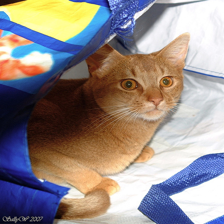

In [11]:
# here is the example of the image data
first_image = Image.open('images/'+trainval_images['image'][0]+ '.jpg').resize((224,224))
first_image

## Pre-processing the data

### save model

In [0]:
preprocess = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
              std=[0.229, 0.224, 0.225]),])

In [0]:
num_image = 3680

In [0]:
tensor_zeros = torch.zeros((num_image,3,224,224))

In [0]:
# this may takes a while
for i in range(num_image):
  input_image = Image.open('images/'+trainval_images['image'][i]+ '.jpg').resize((224,224))
  processed_image = preprocess(input_image.convert('RGB'))
  tensor_zeros[i] = processed_image

In [0]:
# since this step takes so long,
# we convert to numpy save as numpy in case we want it later
array_image = tensor_zeros.numpy()

In [0]:
# this file is really quite big, so if don't need it, don't have to do this step
np.save('oxford_pet_numpy_array_Apr09',array_image)

In [0]:
del array_image #this numpy is pretty big, we will delete after we don't need it

### re-load the model

In [0]:
array_image = np.load('oxford_pet_numpy_array_Apr09.npy')
trainval_images = pd.read_csv('annotations/trainval.txt',sep = ' ',header=None,names= ['image','class','species','breed'])
if min(trainval_images['class']) == 1:
  trainval_images['class'] = trainval_images['class'] - 1

In [0]:
tensor_images = torch.tensor(array_image)

In [0]:
del array_image

In [16]:
tensor_images.shape

torch.Size([3680, 3, 224, 224])

In [0]:
X_train, X_val, y_train, y_val = train_test_split(tensor_images, trainval_images['class'], 
                                  test_size=0.2, random_state=42)

In [0]:
batch_size = 32
trainset = TensorDataset(X_train,torch.Tensor(y_train.values))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)

In [0]:
valset = TensorDataset(X_val,torch.Tensor(y_val.values))
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, drop_last=False)

# 3.  pre-trained model as encoder

We will load the model and swap in the final classification layer that previously maps 2048 layers to 1000 classes, will now maps to 37 classes.

Note that we will freeze the weights in all upstream layers. So the trainable parameters are just the weights and the biases of the newly swapped in layer only.

In [20]:
resnet50 = torchvision.models.resnet50(pretrained=True)

In [21]:
summary(resnet50,(3,224,224),64,'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]           4,096
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
             ReLU-10           [64, 64, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]          16,384
      BatchNorm2d-12          [64, 256, 56, 56]             512
           Conv2d-13          [64, 256, 56, 56]          16,384
      BatchNorm2d-14          [64, 256,

In [0]:
for param in resnet50.parameters():
  param.requires_grad = False
resnet50.fc = nn.Linear(2048,37)  
# we just swap in the fully connected layer (fc) from (2048, 1000) to (2048,37)

In [23]:
summary(resnet50,(3,224,224),64,'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]           4,096
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
             ReLU-10           [64, 64, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]          16,384
      BatchNorm2d-12          [64, 256, 56, 56]             512
           Conv2d-13          [64, 256, 56, 56]          16,384
      BatchNorm2d-14          [64, 256,

Note the number of trainable parameters is 75,813. And the non-trainable parameters are 23M. This is because we freezed the weight of any other layer besides the last fully connected.

# 4. transfer learning in Pytorch 

In [24]:
resnet50 = resnet50.to(device)
print(device) 
# for trouble-shooting, change device to 'cpu' since it's easier to debug.

cuda


In [0]:
def count_accuracy(pred,target):
  """return the accuracy score of a batch"""
  temp = target.detach().cpu().numpy()
  return np.sum(np.where(np.argmax(F.softmax(pred,dim=1).detach().cpu().numpy(),axis=1)
             == temp,1,0))/len(temp)

In [0]:
epoch_train_loss = []
iter_train_loss = []
epoch_train_accuracy = []

epoch_val_loss = []
epoch_val_accuracy = []

In [0]:
learning_rate = 0.0001
epochs = 20
decay = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=learning_rate,weight_decay=decay)

In [28]:
for epoch in range(epochs):
  resnet50.train()
  temp_loss = []
  temp_accu = []
  for x, y in train_loader:
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device,dtype=torch.long)
    output = resnet50(x)
    loss = criterion(output,y)
    temp_loss.append(loss.item())
    iter_train_loss.append(loss.item())
    temp_accu.append(count_accuracy(output,y))
    loss.backward()
    optimizer.step()
  epoch_train_loss.append(np.mean(temp_loss))
  epoch_train_accuracy.append(np.mean(temp_accu))

  resnet50.eval()
  temp_loss = []
  temp_accu = []
  for x, y in val_loader:
    x, y = x.to(device), y.to(device,dtype=torch.long)
    output = resnet50(x)
    loss = criterion(output,y)
    temp_loss.append(loss.item())
    temp_accu.append(count_accuracy(output,y))
  epoch_val_loss.append(np.mean(temp_loss))
  epoch_val_accuracy.append(np.mean(temp_accu))

  if epoch % 2 ==0:
    print('epoch = {}'.format(len(epoch_train_loss)),
          'train accuracy = {:.3f}'.format(epoch_train_accuracy[-1]),
          'validation accuracy = {:.3f}'.format(epoch_val_accuracy[-1]))

epoch = 1 train accuracy = 0.344 validation accuracy = 0.598
epoch = 3 train accuracy = 0.837 validation accuracy = 0.849
epoch = 5 train accuracy = 0.900 validation accuracy = 0.878
epoch = 7 train accuracy = 0.911 validation accuracy = 0.904
epoch = 9 train accuracy = 0.922 validation accuracy = 0.914
epoch = 11 train accuracy = 0.932 validation accuracy = 0.906
epoch = 13 train accuracy = 0.939 validation accuracy = 0.910
epoch = 15 train accuracy = 0.938 validation accuracy = 0.914
epoch = 17 train accuracy = 0.940 validation accuracy = 0.908
epoch = 19 train accuracy = 0.946 validation accuracy = 0.913


I'm going to save the weight parameters of the model, so we don't have to re-train the next time we run this notebook again. We will simply instantiate the resnet model, swap in the final layer, and plug in the trained weights.

In [0]:
torch.save(resnet50.state_dict(), 'torch_weight_finetuned_resnet50_Oxford_pet_Apr09.pt')

# 5. visualization

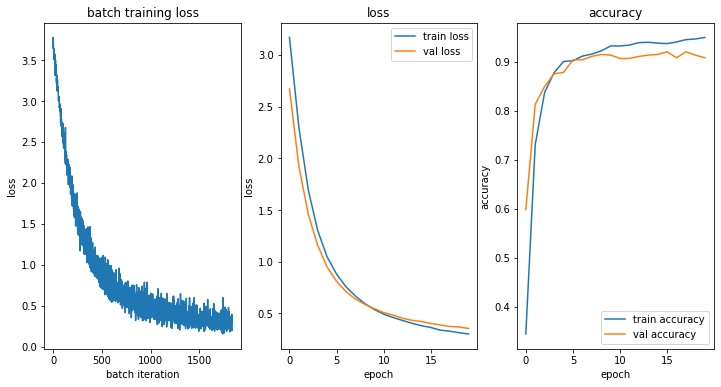

In [30]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].plot(iter_train_loss)
ax[1].plot(epoch_train_loss, label = 'train loss')
ax[1].plot(epoch_val_loss, label = 'val loss')
ax[2].plot(epoch_train_accuracy, label = 'train accuracy')
ax[2].plot(epoch_val_accuracy, label = 'val accuracy')
ax[0].set_title('batch training loss')
ax[1].set_title('loss')
ax[2].set_title('accuracy')
ax[0].set_xlabel('batch iteration')
ax[0].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('accuracy')
ax[1].legend()
ax[2].legend()

Here we will retrieve the predicted labels to plot the confusion matrix. Just to show how 

In [0]:
pred_list = []
target_list = []

resnet50.eval()
for x, y in val_loader:
  x, y = x.to(device), y.to(device,dtype=torch.long)
  output = resnet50(x)
  pred_list.append(np.argmax(F.softmax(output,dim=1).detach().cpu().numpy(),axis=1))
  target_list.append(y.detach().cpu().numpy())

In [0]:
pred_list = np.array(pred_list)
pred_list = pred_list.reshape(-1,1)

In [0]:
target_list = np.array(target_list)
target_list = target_list.reshape(-1,1)

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
confuse_array = confusion_matrix(target_list, pred_list,normalize='true')

Text(0.5, 1.0, 'confusion matrix of the fine-tuned resnet for transfer learning')

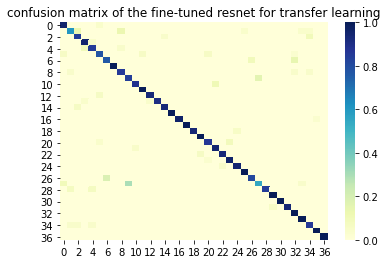

In [36]:
sns.heatmap(confuse_array,cmap="YlGnBu")
plt.title('confusion matrix of the fine-tuned resnet for transfer learning')

So this is just a first try, and as you can see we already have validated accuracy about 0.9. And this might get even better if we play around with parameter search, and train longer. And in the end if we are going to check the test accuracy further, we can use the combine the validation set for the training. Since we are limited in the data, adding the validation back might can help with the training. Also, if we really need to, we can also make a synthetic data, such as cropping or rotating, from the data we already have. 


But the bottom line here is that just this first attempt is already pretty good. 

# Citation

1. [the Oxford dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) 

dataset containing images of cats and dogs of 37 breeds. Each breed has about 200 images. The images have a large variations in scale, pose and lighting.

2. [resnet 50](https://arxiv.org/abs/1512.03385)

The original publication of resnet, containing a strategy for training a very deep convolutional neural net.